#  Coherent J/$\psi$ production in ultraperipheral PbPb collisions at $\sqrt{s_{_{\text{NN}}}}=5.02$ TeV

In [1]:
import ROOT
import sys
import pandas as pd
import numpy as np
sys.path.append('snippets')
from helpers import *
from fit_plot import *
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

Welcome to JupyROOT 6.30/04


## Extracting coherent J/$\psi$ fraction

This notebook is part of the Heavy Ion Exercise for the CERN CMSDAS School 2024.

We assume that you have skimmed the data and simulation, made a first inspection and you are now ready to dive into the core of the analysis.
Let's continue by fitting the J$/\psi$ $p_\text{T}$ spectra to extract the coherent J$/\psi$ fraction.

The simulations were produced using the [STARlight](https://starlight.hepforge.org/) generator and the CMS detector was simulated using [GEANT4](https://geant4.web.cern.ch/). STARlight is a MC generator that simulates two-photon and photon-Pomeron interactions between relativistic nuclei and protons. It is capable of producing several final states, such as coherent and incoherent vector mesons (e.g. J$/\psi$ and $\psi(\text{2S})$) in photo-nuclear interactions.

The following list of processes were simulated using STARlight:
* Coherent J$/\psi \rightarrow \mu^{+}\mu^{-}$, labelled as "CohJpsiToMuMu".
* Incoherent J$/\psi \rightarrow \mu^{+}\mu^{-}$, labelled as "InCohJpsiToMuMu".
* Coherent $\psi(\text{2S}) \rightarrow \text{J}/\psi + X \rightarrow \mu^{+}\mu^{-} + X$, labelled as "CohPsi2SFeeddownToMuMu".
* $\gamma\gamma \rightarrow \mu^{+}\mu^{-}$, labelled as "LowMassGammaGammaToMuMu".

![diagram](img/feynmann_diagram.png)

The process of incoherent J$/\psi \rightarrow \mu^{+}\mu^{-}$ with nucleon dissociation, not included in the STARlight MC but present in data, is taken into account, to describe the large transverse momentum region, with a template based on the [H1 parameterisation](http://dx.doi.org/10.1140/epjc/s10052-013-2466-y) of this process, defined as:
$$
\frac{\text{d}N}{\text{d}p_\text{T}} \approx p_\text{T} \times \left(1 + \left(\frac{b_\text{pd}}{n_\text{pd}}\right) \times p_\text{T}^{2}\right)^{-n_\text{pd}}
$$

In the following cell, we will produce a template for each simulated process by applying the same event selection as in data and creating a histogram of the corresponding  $p_\text{T}$ spectra.

In [2]:
vars = [ROOT.RooRealVar('mass', 'm', 2.4, 4.2, 'GeV/c^{2}'), ROOT.RooRealVar('arap', '|y|', 0.0, 2.4, ''), ROOT.RooRealVar('pt', 'p_{T}', 0.0, 3.0, 'GeV/c')]

#extract the simulated data
def getDataset(inname):
    #extract rdataframe
    ROOT.ROOT.EnableImplicitMT()
    df = ROOT.RDataFrame('Events', inname)
    
    #apply selections
    df = df.Filter('rec_dimuon_charge==0 && rec_dimuon_selection') \
           .Filter('rec_dimuon_softid && rec_dimuon_trigger && event_preselection')
    
    #convert dataframe
    df = pd.DataFrame(df.AsNumpy(['rec_dimuon_pt', 'rec_dimuon_rapidity', 'rec_dimuon_mass']))
    
    #convert to RooDataSet
    data = ROOT.RooDataSet.from_numpy({"mass": df['rec_dimuon_mass'], "arap": np.abs(df['rec_dimuon_rapidity']), "pt": df['rec_dimuon_pt']}, vars)
    data.SetName('data')
    
    print(f'Processed: {len(df)} simulated events from {inname}')
    ROOT.ROOT.DisableImplicitMT()
    return data


inputs = {'CohJpsiToMuMu': '/eos/user/c/cmsdas/2024/long-ex-hin/simulation/HiForestAOD_CohJpsiToMuMu.root',
          'CohPsi2SFeeddownToMuMu': '/eos/user/c/cmsdas/2024/long-ex-hin/simulation/HiForestAOD_CohPsi2SFeeddownToMuMu.root',
          'InCohJpsiToMuMu': '/eos/user/c/cmsdas/2024/long-ex-hin/simulation/HiForestAOD_InCohJpsiToMuMu.root',
          'LowMassGammaGammaToMuMu': '/eos/user/c/cmsdas/2024/long-ex-hin/simulation/HiForestAOD_LowMassGammaGammaToMuMu.root'}

dataset = {}
for key, value in inputs.items():
    dataset[key] = getDataset(f'skim/{key}.root')
    
#extract the real data
df = ROOT.RDataFrame('Events','skim/data.root')
df = df.Filter('rec_dimuon_charge==0 && rec_dimuon_softid')
df = pd.DataFrame(df.AsNumpy(['rec_dimuon_mass', 'rec_dimuon_rapidity', 'rec_dimuon_pt']))
dataset['data'] = ROOT.RooDataSet.from_numpy({"mass": df['rec_dimuon_mass'], "arap": np.abs(df['rec_dimuon_rapidity']), "pt": df['rec_dimuon_pt']}, vars)
dataset['data'].SetName('data')

Processed: 483294 simulated events from skim/CohJpsiToMuMu.root
Processed: 797242 simulated events from skim/CohPsi2SFeeddownToMuMu.root
Processed: 998164 simulated events from skim/InCohJpsiToMuMu.root
Processed: 235806 simulated events from skim/LowMassGammaGammaToMuMu.root
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 11646 out-of-range events
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 3103 out-of-range events


Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly


Next we procede to prepare the model in the workspace, by importing each template as a RooHistPdf.

In [7]:
w = {}
bins = [1.6, 1.9, 2.1, 2.4]

for i in range(3):
    print(f'Preparing workspace for bin: {bins[i]} <= |y| < {bins[i+1]} , 2.95 < mass < 3.25 GeV/c^2')
    #start a fitting workspace
    w[i] = ROOT.RooWorkspace("w")

    #define the bin variables
    w[i].factory('arap[0.0, 2.5]')
    w[i].factory('mass[2.6,4.0]')

    #define the observable
    w[i].factory('pt[1E-4, 3]')
    w[i].var('pt').setBins(200)

    #create model
    ylist = 'N_InCohJpsiToMuMuWithDis[1E4, 0, 1E6] * model_InCohJpsiToMuMuWithDis'
    w[i].factory("RooGenericPdf::model_InCohJpsiToMuMuWithDis('@0 * TMath::Power(1 + (@1 / @2)*@0*@0, -@2)', {pt, bpd[1.79, 0, 5], npd[3.58, 0, 10]})")

    #add templates
    for key, ds in dataset.items():
        if key=='data': continue
        data = ds.reduce(w[i].var('pt'), f'(arap>={bins[i]} && arap<{bins[i+1]}) && (mass>2.95 && mass<3.25) && pt>=0')
        data = data.binnedClone()
        data.SetName(key)
        w[i].Import(data)
        pdf = ROOT.RooHistPdf(f'model_{key}', '', w[i].var('pt'), w[i].data(key), 0)
        w[i].Import(pdf)
        ylist += f', N_{key}[1E4, 0, 1E6] * model_{key}'

    w[i].factory(f'SUM::model({ylist})')

    #now import the data
    data = dataset['data']
    data = data.reduce(w[i].var('pt'), f'(arap>={bins[i]} && arap<{bins[i+1]}) && (mass>2.95 && mass<3.25) && pt>=0')
    w[i].Import(data)
    
    #snapshot initial values
    w[i].saveSnapshot('initial_setting', w[i].allVars())

Preparing workspace for bin: 1.6 <= |y| < 1.9 , 2.95 < mass < 3.25 GeV/c^2
Preparing workspace for bin: 1.9 <= |y| < 2.1 , 2.95 < mass < 3.25 GeV/c^2
Preparing workspace for bin: 2.1 <= |y| < 2.4 , 2.95 < mass < 3.25 GeV/c^2


Then we fit the results and compute the yields in the $p_\text{T} < 0.2$ GeV kinematic region (same as used in the invariant mass fit).

In [10]:
import ROOT.RooFit as RF

#perform fit
for i in range(3):
    print(f'Performing pt fit for bin: {bins[i]} <= |y| < {bins[i+1]} , 2.95 < mass < 3.25 GeV/c^2')
    w[i].loadSnapshot('initial_setting')

    data = w[i].data('data')
    fitResult = w[i].pdf('model').fitTo(data, RF.NumCPU(2), RF.PrintLevel(-1), RF.Save(1))
    fitResult.Print()
    
    #extract results at pt < 0.2 GeV/c
    yields = {}
    frac = {}
    w[i].var('pt').setRange("signal", 1e-4, 0.21)
    for key in ['CohJpsiToMuMu', 'InCohJpsiToMuMu', 'InCohJpsiToMuMuWithDis','CohPsi2SFeeddownToMuMu']:
        frac[key] = w[i].pdf(f'model_{key}').createIntegral(w[i].var('pt'), RF.NormSet(w[i].var('pt')), RF.Range("signal")).getVal()
        yields[key] = frac[key] * w[i].var(f'N_{key}').getVal()
    
    print(f'Results for bin: pt < 0.2 GeV/c , {bins[i]} <= |y| < {bins[i+1]} , 2.95 < mass < 3.25 GeV/c^2')
    fI = (yields['InCohJpsiToMuMu'] + yields['InCohJpsiToMuMuWithDis'])/yields['CohJpsiToMuMu']

    w[i].factory(f"RooFormulaVar::fI('({frac['InCohJpsiToMuMu']}*@0+{frac['InCohJpsiToMuMuWithDis']}*@1)/({frac['CohJpsiToMuMu']}*@2)', {{N_InCohJpsiToMuMu,N_InCohJpsiToMuMuWithDis,N_CohJpsiToMuMu}})")
    print('fI=',w[i].function('fI').getVal(),'+/-',w[i].function('fI').getPropagatedError(fitResult))

    fD = yields['CohPsi2SFeeddownToMuMu']/yields['CohJpsiToMuMu']
    print(f'N_CohJpsiToMuMu = {yields["CohJpsiToMuMu"]}')
    print(f'f_I = {fI} fD = {fD}')

Performing pt fit for bin: 1.6 <= |y| < 1.9 , 2.95 < mass < 3.25 GeV/c^2
Results for bin: pt < 0.2 GeV/c , 1.6 <= |y| < 1.9 , 2.95 < mass < 3.25 GeV/c^2
fI= 0.019656711989075853 +/- 0.0033056998558954097
N_CohJpsiToMuMu = 5734.219258007074
f_I = 0.021501388896249817 fD = 0.04663050997278678
Performing pt fit for bin: 1.9 <= |y| < 2.1 , 2.95 < mass < 3.25 GeV/c^2
Results for bin: pt < 0.2 GeV/c , 1.9 <= |y| < 2.1 , 2.95 < mass < 3.25 GeV/c^2
fI= 0.02192236247827168 +/- 0.006769447405496654
N_CohJpsiToMuMu = 16622.11061000366
f_I = 0.02395616653405853 fD = 0.04693399303090683
Performing pt fit for bin: 2.1 <= |y| < 2.4 , 2.95 < mass < 3.25 GeV/c^2
Results for bin: pt < 0.2 GeV/c , 2.1 <= |y| < 2.4 , 2.95 < mass < 3.25 GeV/c^2
fI= 0.019566782251562245 +/- 0.0006538238215368535
N_CohJpsiToMuMu = 13090.303561311715
f_I = 0.021428659660498707 fD = 0.04923159165556506

  RooFitResult: minimized FCN value: -96064.9, estimated distance to minimum: 5.2006e-05
                covariance matrix qu

Finally we display the fit results

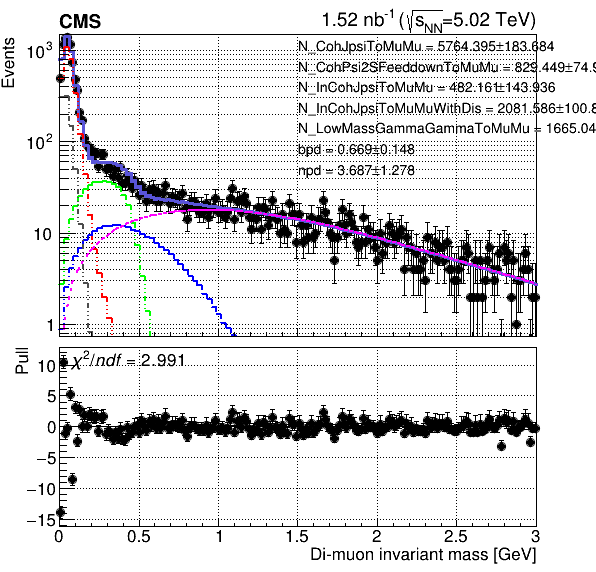

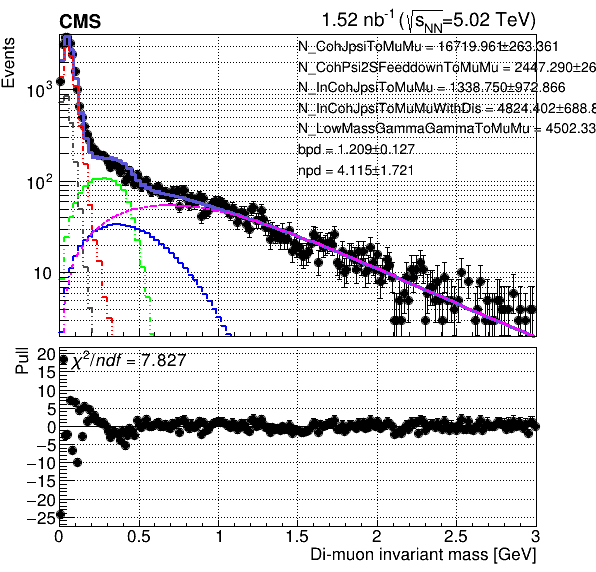

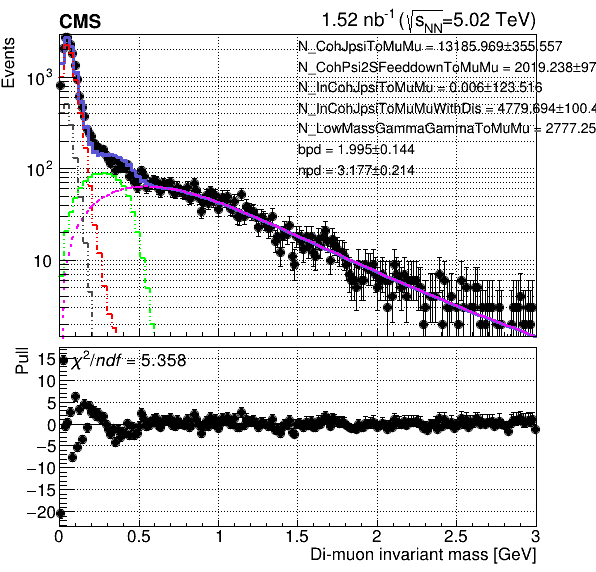

In [5]:
canvas=[]
components= ['model_CohJpsiToMuMu', 'model_CohPsi2SFeeddownToMuMu',
             'model_InCohJpsiToMuMu', 'model_InCohJpsiToMuMuWithDis',
             'model_LowMassGammaGammaToMuMu']
for i in range(3):
    canvas.append(
        plotFitResults(w[i],
                       model=w[i].pdf('model'),
                       data=w[i].data('data'),
                       cname=f'fit1{i}',
                       varname='pt',
                       components=components,
                       component_colors=[2,3,4,6,12])
    )
    canvas[i].cd(1).SetLogy()

Inspect the quality of the fits and see if they can be improved:
* One way to improve the fits is by constraining the normalization of the templates from feed-down ($\psi(\text{2S}) \rightarrow \text{J}/\psi + X \rightarrow \mu^{+}\mu^{-} + X$) and by fixing the normalization of the QED background ($\gamma\gamma \rightarrow \mu^{+}\mu^{-}$) to the results from the invariant mass fits.
* Keep in mind the different invariant mass and $p_\text{T}$ kinematic regions when comparing between different fits.